In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import numpy as np
import glob
import re
import pandas as pd
import seaborn as sns
import math

def get_test_data(filename,num_per_batch=8):
    '''
    This function takes a pickle file assumed to be a dictionary with the following data:
        predictions->[], target->[], RMSE:value, R2: value, Traintimes->[tuples], Testtimes->[tuples]
        
    1) We parse out the RMSE and R2 values, and make sure they match the given predictions and target array
    2) We then calculate the mean and std of the time per batch for the combined training and testing data
    
    Return values from 1 and 2
    '''
    
    data=pickle.load(open(filename,'rb'))
    
    cRMSE=np.sqrt(np.mean((data['predicted']-data['target'])**2))
    dRMSE=data['RMSE']
    cR2=np.corrcoef(data['predicted'],data['target'])[0][1]**2
    dR2=data['R2']
    assert ("%12f"%dRMSE=="%12f"%cRMSE),f'Calc: {cRMSE} , Dic: {dRMSE}'
    assert ("%12f"%dR2=="%12f"%cR2),f'Calc: {cR2} , Dic: {dR2}'
    
    times=[]
    for tup in data['Traintimes']:
        times.append(tup[1]/num_per_batch)
    for tup in data['Testtimes']:
        times.append(tup[1]/num_per_batch)
    
    mean_time=np.mean(times)
    std_time=np.std(times)
    return data['RMSE'],data['R2'],mean_time,std_time,data['predicted'],data['target']

def get_stats(pred, gold):
    rmse=np.sqrt(np.mean((pred-gold)**2))
    r2=np.corrcoef(pred,gold)[0][1]**2
    return(rmse,r2)

def parse_slurm_output(filename):
    '''
    This function parses the needed values from the slurm output from the training script
    
    Basically, it grabs the Number of parameters and returns them along with the model name
    '''
    
    param_num=0
    saved=''
    train_time=''
    test_time=''
    seen=False
    
    with open(filename) as infile:
        for line in infile:
            if 'Outfile Prefix: ' in line:
                saved=line.rstrip().split()[-1]
            elif 'Number of parameters: ' in line:
                param_num=int(line.rstrip().split()[-1])
            elif "Overall Time:" in line:
                time=float(line.rstrip().split()[-1])
                if not seen:
                    train_time=time
                    seen=True
                else:
                    test_time=time
    return saved, param_num, train_time, test_time

def gen_key(row):
    if 'aqsol_' in row['Name']:
        return re.split(r'aqsol_scaf_2d_\d_',row['Name'])[1]
    else:
        return 'na'

In [ ]:
def gen_key(filename,prefix=''):
    '''
    This function generates the key from the file name used in the dictionary below
    '''
    
    if '_2d_' in filename:
        dimension='_2d'
    else:
        dimension=''
    
    if '_cpu_' in filename:
        cpu='_cpu'
    else:
        cpu=''
    
    fold=re.search("_\d_",filename).group(0)
    
    garbage=prefix+dimension+cpu+fold
    
    if 'trainepochlosses' in filename:
        key=filename.split(garbage)[-1].split('_trainepochlosses.pi')[0]+dimension
    elif 'losses' in filename:
        key=filename.split(garbage)[-1].split('_trainlosses.pi')[0]+dimension
    else:
        key=filename.split(garbage)[-1].split('_testdic.pi')[0]+dimension
    
    return key

## First round of data analysis

In [42]:
data_count=9982.0
batch_size=8.0
prefix='aqsol_scaf'

data={} #dictionary of model name:{TrainR2:[], TrainRMSE:[], TestR2:[], TestRMSE:[], mean_gpu_times:[], std_gpu_times:[],mean_cpu_times:[], std_cpu_times:[],params:value}

#first we initialize the data dictionary -- makes it easier to obtain all the values after
for fold in ['_0_','_1_','_2_']:
    for dimension in ['','_2d']:
        garbage=prefix+dimension+fold
        for item in glob.glob('TopModelComp/'+garbage+'*testdic.pi'):
            key=gen_key(item,prefix)
            if key not in data:
                data[key]={'TestR2':None,'TestRMSE':None,
                           'mean_gpu_times':None,'std_gpu_times':None,
                           'mean_cpu_times':None,'std_cpu_times':None,
                           'params':None,'Fold0R2':None,'Fold0RMSE':None,'Fold1R2':None,'Fold1RMSE':None,'Fold2R2':None,'Fold2RMSE':None
                          }

In [43]:
#gathering the slurm job outputs -- to fill the parameters per key
todo=glob.glob('slurm-*.out')

for item in todo:
    f,p=parse_slurm_output(item)
    k=gen_key(f,prefix)
    if data[k]['params']:
        assert data[k]['params']==p
    else:
        data[k]['params']=p

In [44]:
#Now we will populate the rest of the dictionary

for k in data.keys():
    files=glob.glob('TopModelComp/*'+k.split('_2d')[0]+'*testdic.pi')
    cpufiles=glob.glob('TopModelCPUComp/*'+k.split('_2d')[0]+'*testdic.pi')
    if '2d' in k:
        files=[x for x in files if '_2d_' in x]
        cpufiles=[x for x in cpufiles if '_2d_' in x]
    else:
        files=[x for x in files if '_2d_' not in x]
        cpufiles=[x for x in cpufiles if '_2d_' not in x]
    
    
    preds=np.array([])
    golds=np.array([])
    mgpus=[]
    sgpus=[]
    mcpus=[]
    scpus=[]
    for f in files:
        frmse, fr2, mtime, stime, p, g = get_test_data(f,batch_size)
        if '_0_' in f:
            data[k]['Fold0R2']=fr2
            data[k]['Fold0RMSE']=frmse
        elif '_1_' in f:
            data[k]['Fold1R2']=fr2
            data[k]['Fold1RMSE']=frmse
        elif '_2_' in f:
            data[k]['Fold2R2']=fr2
            data[k]['Fold2RMSE']=frmse
            
        preds=np.append(preds,p.tolist())
        golds=np.append(golds,g.tolist())
        mgpus.append(mtime)
        sgpus.append(stime)
    cvrmse,cvr2=get_stats(preds,golds)
    data[k]['TestRMSE']=cvrmse
    data[k]['TestR2']=cvr2
    data[k]['mean_gpu_times']=np.mean(mgpus)
    data[k]['std_gpu_times']=np.mean(sgpus)
    for f in cpufiles:
        _,_, mtime, stime, _,_ = get_test_data(f,batch_size)
        mcpus.append(mtime)
        scpus.append(stime)
    data[k]['mean_cpu_times']=np.mean(mcpus)
    data[k]['std_cpu_times']=np.mean(scpus)

In [45]:
data

{'drop0.1_ldist0.0_lattn0.33_Ndense1_heads8_dmodel1024_nsl8': {'TestR2': 0.6001332295286447,
  'TestRMSE': 1.6684248707331923,
  'mean_gpu_times': 0.0038216848197019,
  'std_gpu_times': 0.0010357504422309795,
  'mean_cpu_times': 0.07659623286344557,
  'std_cpu_times': 0.08263335068235707,
  'params': 42049537,
  'Fold0R2': 0.760650411998446,
  'Fold0RMSE': 1.2364346202834156,
  'Fold1R2': 0.37809039016409135,
  'Fold1RMSE': 2.3619018908301093,
  'Fold2R2': 0.7242020034601635,
  'Fold2RMSE': 1.1153637507658007},
 'drop0.1_ldist0.0_lattn0.25_Ndense1_heads16_dmodel1024_nsl16': {'TestR2': 0.6458140990488007,
  'TestRMSE': 1.4868477905762634,
  'mean_gpu_times': 0.005623014468667854,
  'std_gpu_times': 0.0012352639752419617,
  'mean_cpu_times': 0.15065564129215023,
  'std_cpu_times': 0.19139493265282517,
  'params': 84066305,
  'Fold0R2': 0.7804621547464818,
  'Fold0RMSE': 1.1394825856817286,
  'Fold1R2': 0.4593676166318721,
  'Fold1RMSE': 2.035816330455286,
  'Fold2R2': 0.7206858821934506,

In [46]:
#sorting models based on number of parameters
order=[]
for k in data.keys():
    if '_2d' in k:
        continue
    order.append((k,data[k]['params']))

In [47]:
order.sort(key=lambda x:x[1])

In [48]:
order

[('drop0.1_ldist0.33_lattn0.25_Ndense1_heads8_dmodel512_nsl16', 21061633),
 ('drop0.1_ldist0.33_lattn0.5_Ndense1_heads16_dmodel512_nsl16', 21061633),
 ('drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmodel512_nsl16', 21061633),
 ('drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmodel512_nsl16', 21061633),
 ('drop0.1_ldist0.0_lattn0.33_Ndense1_heads8_dmodel1024_nsl8', 42049537),
 ('drop0.1_ldist0.33_lattn0.5_Ndense1_heads32_dmodel1024_nsl8', 42049537),
 ('drop0.1_ldist0.0_lattn0.25_Ndense1_heads16_dmodel1024_nsl16', 84066305),
 ('drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmodel1024_nsl16', 84066305),
 ('drop0.1_ldist0.33_lattn0.25_Ndense1_heads8_dmodel1024_nsl16', 84066305),
 ('drop0.1_ldist0.0_lattn0.25_Ndense1_heads8_dmodel1024_nsl16', 84066305)]

In [258]:
for k,p in order:
    print(data[k]['mean_gpu_times'],data[k]['std_gpu_times'],data[k]['mean_cpu_times'],data[k]['std_cpu_times'])
    print(data[k+'_2d']['mean_gpu_times'],data[k+'_2d']['std_gpu_times'],data[k+'_2d']['mean_cpu_times'],data[k+'_2d']['std_cpu_times'])
    print('--------------')

0.005354971075669314 0.0016967707992380776 0.05281293553769844 0.07374138499073189
0.004516421729682858 0.0025349361833151935 0.048036527612970926 0.03757239687642175
--------------
0.007379496310893287 0.003095618041343491 0.05514684309944128 0.1055623030374623
0.0040555864047163576 0.0011241823543443983 0.048503286643033355 0.048324472665906365
--------------
0.006165649694127914 0.0018114829108213683 0.05743324752642304 0.10645285654855043
0.008413394905117331 0.003547925095484758 0.0515618159984931 0.05223463143176995
--------------
0.006324180194901095 0.0013331882665175594 0.05805945336723175 0.11182403514024775
0.005717933727189516 0.0034966401276896875 0.05298486765888002 0.056082723403232594
--------------
0.0038216848197019 0.0010357504422309795 0.07659623286344557 0.08263335068235707
0.0030179091800863925 0.0009390817990283574 0.06569400178188951 0.04108235466533979
--------------
0.003091269729929602 0.0009177522388138783 0.0874733528934228 0.14795140004967103
0.00484904017

In [259]:
with open('model_selection.csv','w') as outfile:
    outfile.write('model,ldist,lattn,heads,dmodel,nstacklayers,params,2D,R2,RMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE\n')
    counter=0
    for k,p in order:
        lattn=re.search('_lattn0.(\d+)',k).group(1)
        ldist=re.search('_ldist0.(\d+)',k).group(1)
        heads=re.search('_heads(\d+)',k).group(1)
        dmodel=re.search('_dmodel(\d+)',k).group(1)
        nsl=re.search('_nsl(\d+)',k).group(1)
        
        for flag in ('','_2d'):
            sent=str(counter)+','+ldist+','+lattn+','+heads+','+dmodel+','+nsl+','+str(p)+','+str(bool(flag))+','+str(data[k+flag]['TestR2'])+','+str(data[k+flag]['TestRMSE'])+','+str(data[k+flag]['Fold0R2'])+','+str(data[k+flag]['Fold0RMSE'])+','+str(data[k+flag]['Fold1R2'])+','+str(data[k+flag]['Fold1RMSE'])+','+str(data[k+flag]['Fold2R2'])+','+str(data[k+flag]['Fold2RMSE'])+'\n'
            outfile.write(sent)
        counter+=1

In [260]:
data=pd.read_csv('model_selection.csv')

In [261]:
data

,model,ldist,lattn,heads,dmodel,nstacklayers,params,2D,R2,RMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE
0,0,33,25,8,512,16,21061633,False,0.680513,1.433898,0.771105,1.190884,0.543271,1.878919,0.715343,1.104492
1,0,33,25,8,512,16,21061633,True,0.617225,1.595822,0.773196,1.165611,0.421934,2.234102,0.702895,1.135987
2,1,33,5,16,512,16,21061633,False,0.680268,1.376835,0.767812,1.182756,0.538129,1.762661,0.706297,1.086903
3,1,33,5,16,512,16,21061633,True,0.626803,1.578471,0.779310,1.160234,0.439146,2.180485,0.693360,1.172343
4,2,0,5,16,512,16,21061633,False,0.640908,1.508071,0.771169,1.183117,0.425059,2.087467,0.735270,1.032430
5,2,0,5,16,512,16,21061633,True,0.630034,1.534702,0.769578,1.177650,0.411687,2.137227,0.728023,1.054373
6,3,0,33,16,512,16,21061633,False,0.631652,1.531405,0.778264,1.154224,0.420021,2.141084,0.724991,1.058064
7,3,0,33,16,512,16,21061633,True,0.686327,1.374425,0.785993,1.144025,0.510813,1.820432,0.739536,1.022066
8,4,0,33,8,1024,8,42049537,False,0.600133,1.668425,0.760650,1.236435,0.378090,2.361902,0.724202,1.115364
9,4,0,33,8,1024,8,42049537,True,0.609472,1.654271,0.773171,1.174898,0.376868,2.381701,0.728723,1.075837


In [216]:
sns.set(font_scale=1.5)

In [276]:
def plotter(xlabel, ylabel,hue, dataframe,savename,ylim=None):
    fig=plt.figure()
    sns.boxplot(xlabel,ylabel,data=dataframe,color="w")
    a=sns.swarmplot(xlabel,ylabel,hue,data=dataframe)
    legend=a.legend()
    legend.remove()
    #plt.legend(bbox_to_anchor=(1.05,1),loc=2)
    if ylim:
        plt.ylim(ylim[0],ylim[1])
    plt.tight_layout()
    
    plt.savefig(savename,dpi=200)

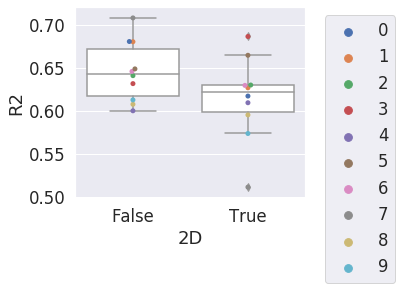

In [273]:
plotter('2D','R2','model',data,'legend.png')

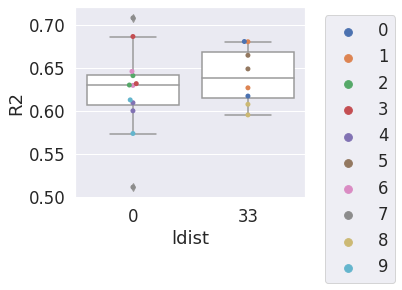

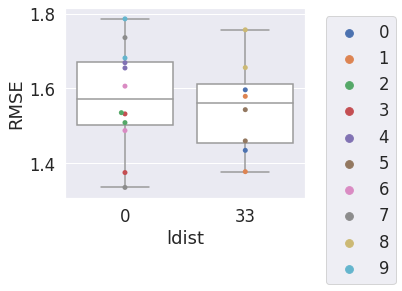

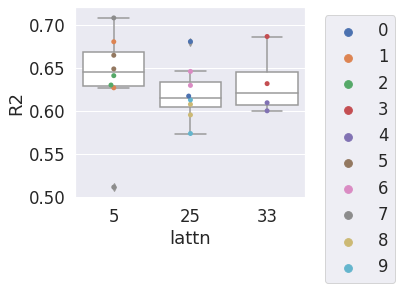

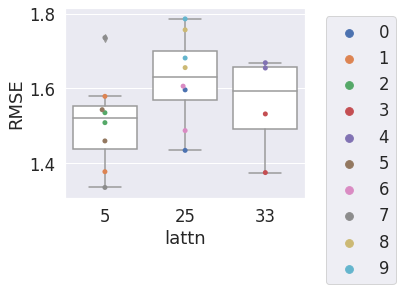

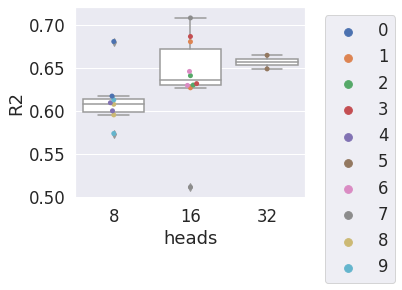

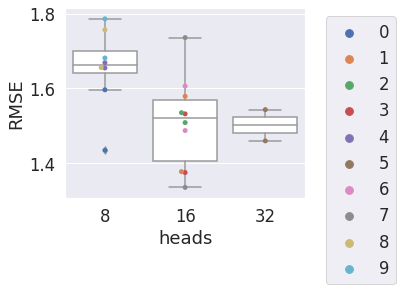

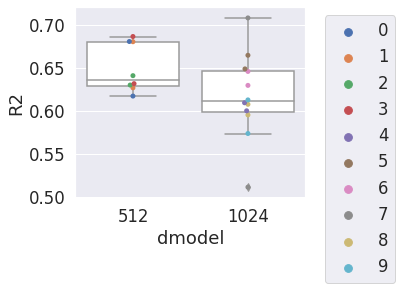

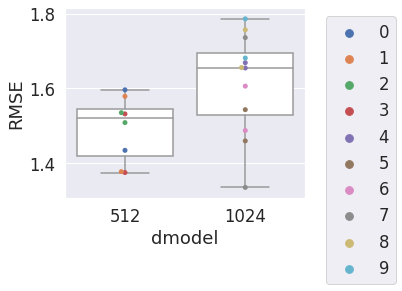

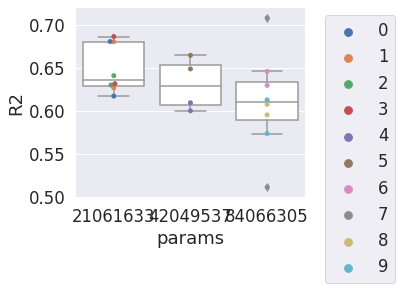

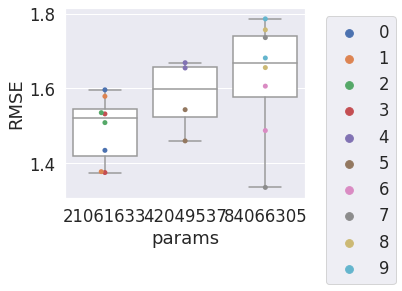

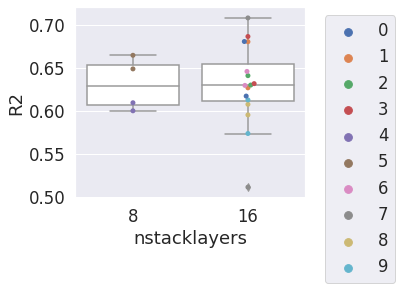

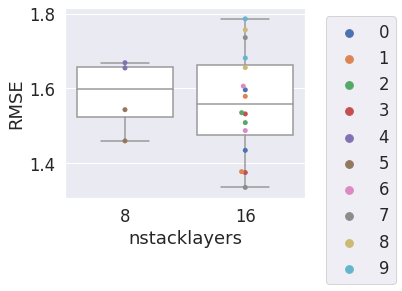

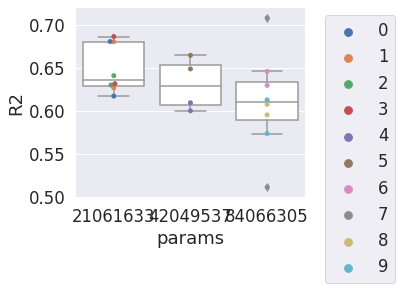

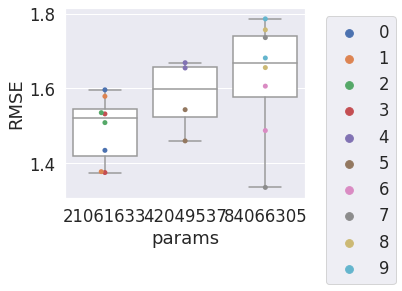

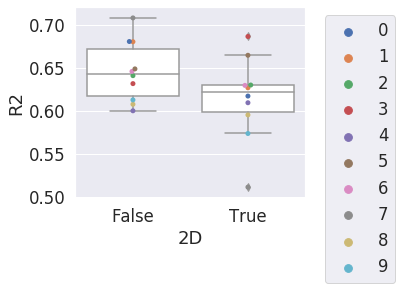

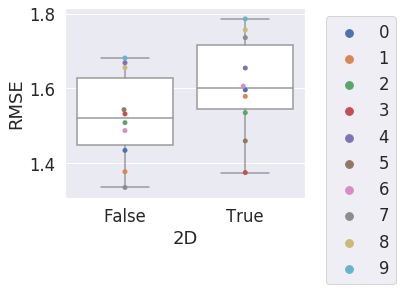

In [274]:
for xlabel in ['ldist','lattn','heads','dmodel','params','nstacklayers','params','2D']:
    plotter(xlabel,'R2','model',data,'testR2_'+xlabel+'.png')
    plotter(xlabel,'RMSE','model',data,'testRMSE_'+xlabel+'.png')

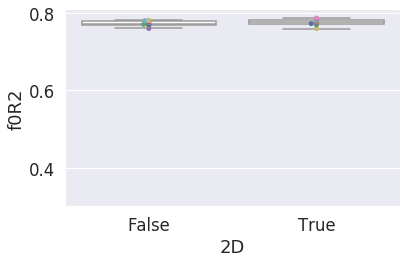

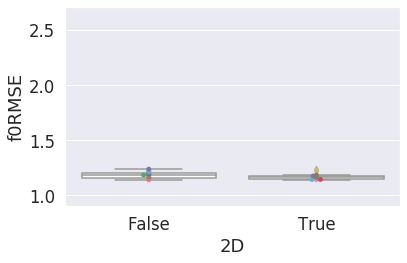

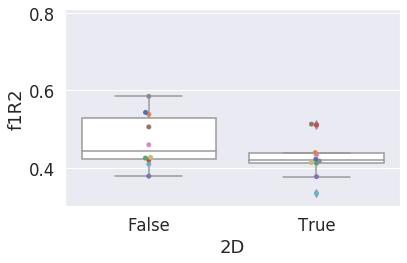

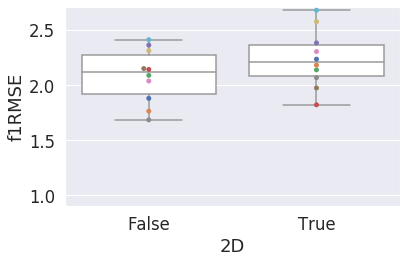

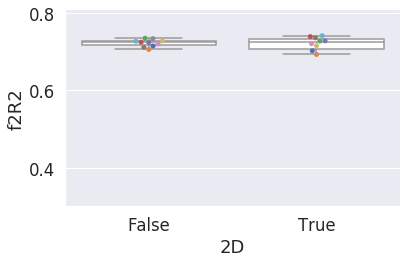

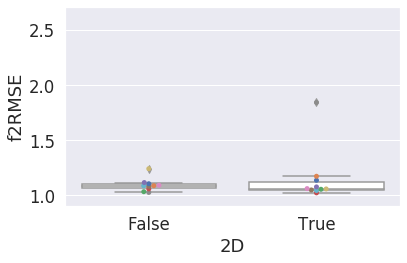

In [279]:
for fold in ['f0','f1','f2']:
    plotter('2D',fold+'R2','model',data,'test'+fold+'R2_2d.png',(0.3,0.81))
    plotter('2D',fold+'RMSE','model',data,'test'+fold+'RMSE_2d.png',(0.9,2.71))

## Convergence analysis

In [7]:
epoch_loss_files=glob.glob("TopModelComp/*trainepochlosses.pi")

In [11]:
loss_files=glob.glob("TopModelComp/*losses.pi")
loss_files=[x for x in loss_files if 'trainepochlosses' not in x]

In [51]:
order

[('drop0.1_ldist0.33_lattn0.25_Ndense1_heads8_dmodel512_nsl16', 21061633),
 ('drop0.1_ldist0.33_lattn0.5_Ndense1_heads16_dmodel512_nsl16', 21061633),
 ('drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmodel512_nsl16', 21061633),
 ('drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmodel512_nsl16', 21061633),
 ('drop0.1_ldist0.0_lattn0.33_Ndense1_heads8_dmodel1024_nsl8', 42049537),
 ('drop0.1_ldist0.33_lattn0.5_Ndense1_heads32_dmodel1024_nsl8', 42049537),
 ('drop0.1_ldist0.0_lattn0.25_Ndense1_heads16_dmodel1024_nsl16', 84066305),
 ('drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmodel1024_nsl16', 84066305),
 ('drop0.1_ldist0.33_lattn0.25_Ndense1_heads8_dmodel1024_nsl16', 84066305),
 ('drop0.1_ldist0.0_lattn0.25_Ndense1_heads8_dmodel1024_nsl16', 84066305)]

In [77]:
def gen_datadic(order, file_list):
    data={} #dictionary of key:{fold:[losses]}
    for key, _ in order:
        toplace=[x for x in file_list if key==gen_key(x)]
        #print(key)
        #print(len(toplace))
        data[key]={}
        for fold in [0,1,2]:
            item=[x for x in toplace if f'_{fold}_' in x][0]
            #print(item)
            data[key][fold]=pickle.load(open(item,'rb'))
    return data

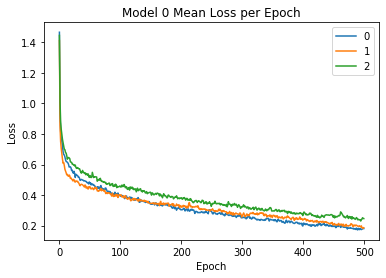

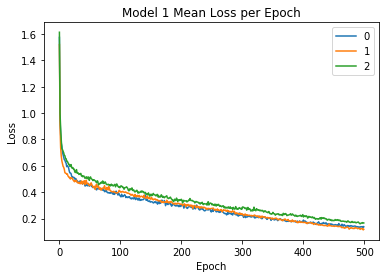

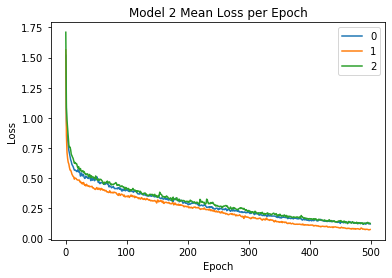

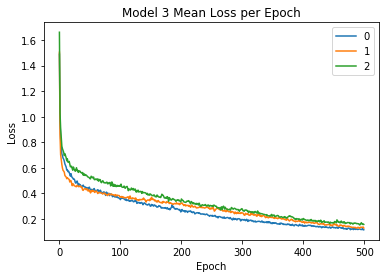

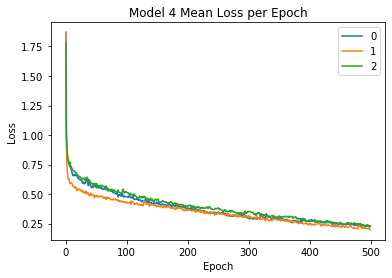

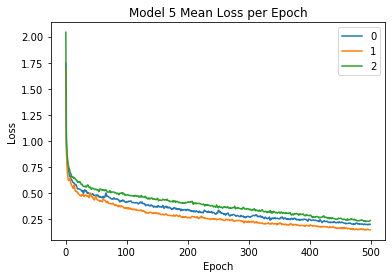

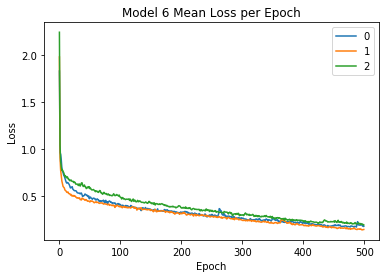

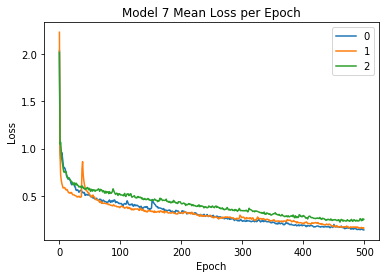

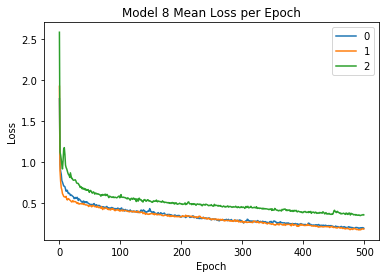

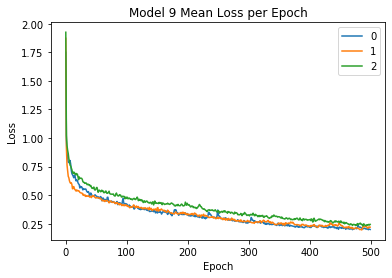

In [78]:
epoch_data=gen_datadic(order,epoch_loss_files)
for i,(k,_) in enumerate(order):
    plt.figure()
    for fold in [0,1,2]:
        plt.plot(epoch_data[k][fold],label=str(fold))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Model {i} Mean Loss per Epoch')
    plt.savefig(f'model{i}_mepochloss.png',dpi=200)

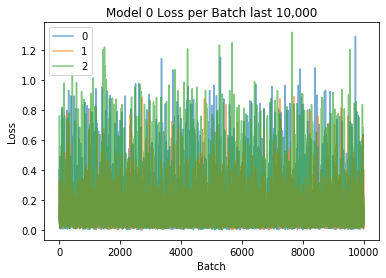

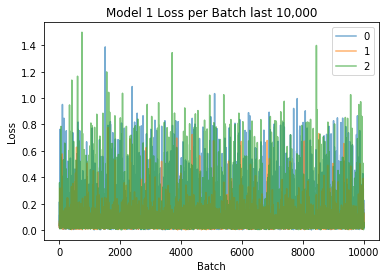

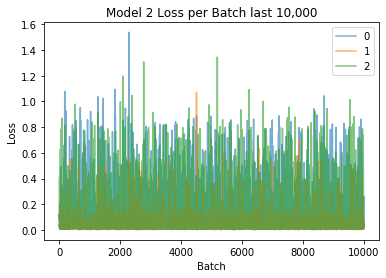

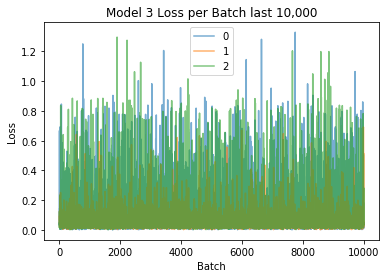

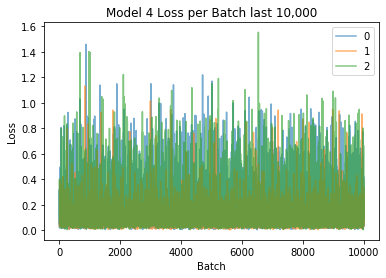

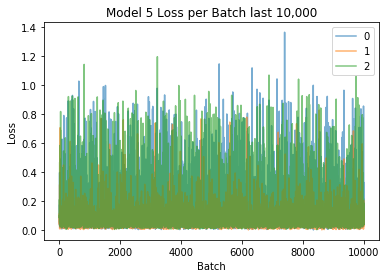

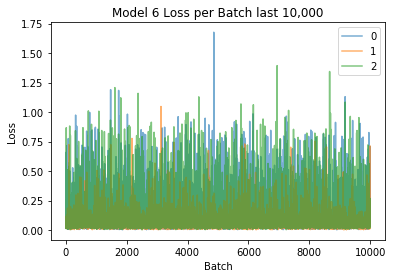

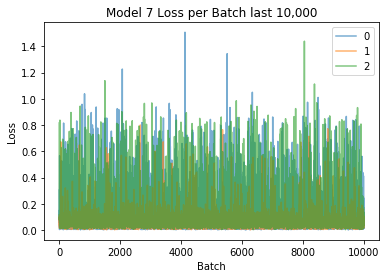

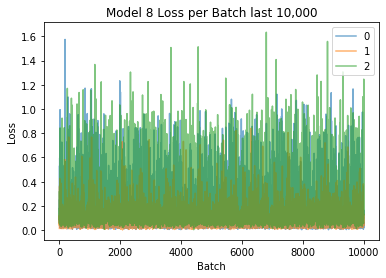

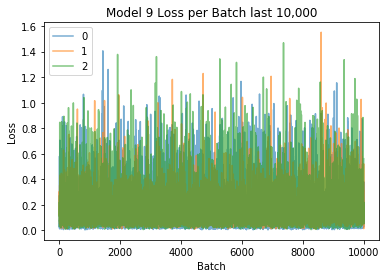

In [82]:
loss_data=gen_datadic(order,loss_files)
for i,(k,_) in enumerate(order):
    plt.figure()
    for fold in [0,1,2]:
        plt.plot(loss_data[k][fold][-10000:],label=str(fold),alpha=0.6)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Model {i} Loss per Batch last 10,000')
    plt.savefig(f'model{i}_loss_last10k.png',dpi=200)

## Looking at distributions of the Solubility scores for train/test

In [5]:
files=glob.glob('data/aqsol/aqsol_scaf_t*.csv')
files.sort()

In [16]:
sol_dic={'train':{},'test':{}}#dic {train/test}->{fold}->[data]

for f in files:
    data=pd.read_csv(f)
    if '_train' in f:
        key1='train'
    else:
        key1='test'
    
    fold=f.split(key1)[-1][0]
    print(fold)
    
    sol_dic[key1][fold]=data['y'].tolist()


0
1
2
0
1
2


61


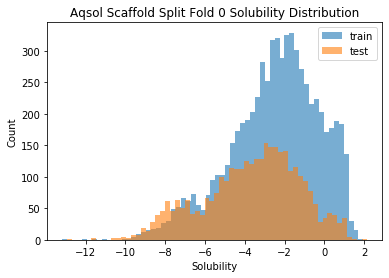

61


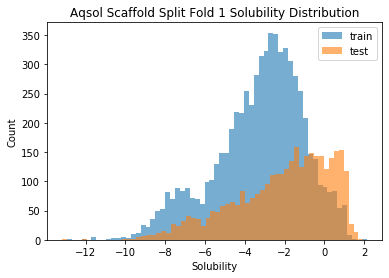

62


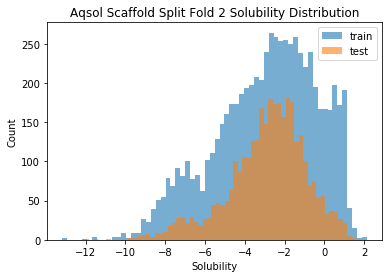

In [35]:
for fold in ['0','1','2']:
    w=0.25
    n=math.ceil((max(sol_dic['train'][fold])-min(sol_dic['train'][fold]))/w)
    print(n)

    plt.figure()
    plt.hist(sol_dic['train'][fold],label='train',alpha=0.6,bins=n)
    plt.hist(sol_dic['test'][fold],label='test',alpha=0.6,bins=n)
    plt.ylabel('Count')
    plt.xlabel('Solubility')
    plt.title('Aqsol Scaffold Split Fold '+fold+' Solubility Distribution')
    plt.savefig('aqsol_scaf'+fold+'_soldist.png',dpi=200)
    plt.legend()
    plt.show()

##  Doing more comparisions for the top10 models

In [78]:
get_test_data("top10/aqsol_scaf_2d_0_drop0.1_ldist0.0_lattn0.25_Ndense1_heads8_dmodel1024_nsl16_testdic.pi")

(1.1625418670935752,
 0.7717673205320053,
 0.006593895288041005,
 0.0018835287595230703,
 array([-2.89420891, -3.55289507,  0.49659538, ..., -1.93961155,
        -3.42361212, -4.98818254]),
 array([-3.30749989, -2.5999999 ,  0.41119999, ..., -0.76999998,
        -3.17370009, -4.82823324]))

In [81]:
data={} #key:{f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE,traintimes,testtimes,ccvR2,ccvRMSE,parameters}
tocheck=set([re.split(r'top10/aqsol_scaf_2d_\d_',x)[1] for x in glob.glob('top10/*testdic.pi')])

In [83]:
for f_name in tocheck:
    #pref,param,traintime,testtime=parse_slurm_output(f_name)
    key=f_name.split('_testdic.pi')[0]
    
    if key not in data:
        data[key]={
            'f0R2':0,
            'f0RMSE':0,
            'f1R2':0,
            'f1RMSE':0,
            'f2R2':0,
            'f2RMSE':0,
            'traintimes':[],
            'testtimes':[],
            'ccvR2':0,
            'ccvRMSE':0,
            'parameters':0
        }
    
    #data[key]['parameters']=param
    #data[key]['traintimes'].append(traintime)
    #data[key]['testtimes'].append(testtime)

In [84]:
todo=set([re.split(r'top10/aqsol_scaf_2d_\d_',x)[1] for x in glob.glob('top10/*testdic.pi')])

prefix='top10/aqsol_scaf_2d_'
for suffix in todo:
    key=suffix.split('_testdic.pi')[0]
    assert key in data
    all_preds=np.array([])
    all_golds=np.array([])
    for fold in ['0','1','2']:
        filename=prefix+fold+'_'+suffix
        fRMSE,fR2,_,_,fpred,fgold=get_test_data(filename)
        all_preds=np.append(all_preds,fpred.tolist())
        all_golds=np.append(all_golds,fgold.tolist())
        
        data[key]['f'+fold+'R2']=fR2
        data[key]['f'+fold+'RMSE']=fRMSE
    
    ccvRMSE,ccvR2=get_stats(all_preds,all_golds)
    data[key]['ccvR2']=ccvR2
    data[key]['ccvRMSE']=ccvRMSE

In [85]:
data

{'drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmodel512_nsl16': {'f0R2': 0.7840278306119212,
  'f0RMSE': 1.1634208320549508,
  'f1R2': 0.4463936411022459,
  'f1RMSE': 2.198964634163914,
  'f2R2': 0.7126273396567114,
  'f2RMSE': 1.0911600806472126,
  'traintimes': [],
  'testtimes': [],
  'ccvR2': 0.6390142138786814,
  'ccvRMSE': 1.568358202755151,
  'parameters': 0},
 'drop0.1_ldist0.33_lattn0.25_Ndense1_heads8_dmodel1024_nsl16': {'f0R2': 0.7802988995823842,
  'f0RMSE': 1.1379515150498645,
  'f1R2': 0.39133053874629553,
  'f1RMSE': 2.4910496175546624,
  'f2R2': 0.7402796491180622,
  'f2RMSE': 1.0484164063779784,
  'traintimes': [],
  'testtimes': [],
  'ccvR2': 0.5887273308326151,
  'ccvRMSE': 1.693015816231412,
  'parameters': 0},
 'drop0.1_ldist0.33_lattn0.5_Ndense1_heads16_dmodel512_nsl16': {'f0R2': 0.7767932142011005,
  'f0RMSE': 1.1607703325660363,
  'f1R2': 0.5126716516168165,
  'f1RMSE': 1.9593014648646792,
  'f2R2': 0.724428639952263,
  'f2RMSE': 1.053933386782714,
  'traintimes'

In [65]:
for key in data:
    print(data[key]['parameters'],np.mean(data[key]['traintimes']),np.mean(data[key]['testtimes']),data[key]['ccvR2'],data[key]['ccvRMSE'])
    print('-------------------')

21061633 42.052311499913536 20.8172607421875 0.6696041855462974 1.4178400916515166
-------------------
21061633 46.71349056561788 23.400291681289673 0.6390142138786814 1.568358202755151
-------------------
21061633 39.64065154393514 20.7470285097758 0.6701936863693878 1.4487613760808207
-------------------
21061633 33.24021363258362 17.593859036763508 0.6444024412495979 1.5243783358565113
-------------------
94570497 55.391934871673584 27.832899888356526 0.6541701201464806 1.4651594548035525
-------------------
84066305 57.637790520985924 27.521541436513264 0.5887273308326151 1.693015816231412
-------------------
84066305 63.45541659990946 30.895668665568035 0.6584035010694538 1.42899387641044
-------------------


In [87]:
for key in data:
    print(data[key]['ccvR2'],data[key]['ccvRMSE'],data[key]['f0R2'],data[key]['f0RMSE'],data[key]['f1R2'],data[key]['f1RMSE'],data[key]['f2R2'],data[key]['f2RMSE'])
    print('-------------------')

0.6390142138786814 1.568358202755151 0.7840278306119212 1.1634208320549508 0.4463936411022459 2.198964634163914 0.7126273396567114 1.0911600806472126
-------------------
0.5887273308326151 1.693015816231412 0.7802988995823842 1.1379515150498645 0.39133053874629553 2.4910496175546624 0.7402796491180622 1.0484164063779784
-------------------
0.6701936863693878 1.4487613760808207 0.7767932142011005 1.1607703325660363 0.5126716516168165 1.9593014648646792 0.724428639952263 1.053933386782714
-------------------
0.6541701201464806 1.4651594548035525 0.7744483681870286 1.1775456485046092 0.47073599283115086 1.987447954076286 0.7287258961770762 1.0506317217061942
-------------------
0.6444024412495979 1.5243783358565113 0.7734038177965025 1.1901027758918943 0.44121499718571067 2.1084159884060174 0.7229561627526816 1.0534658087128315
-------------------
0.6584035010694538 1.42899387641044 0.7717673205320053 1.1625418670935752 0.4697838099909123 1.9264911601728667 0.7325262213966971 1.0312578879

In [66]:
!wc data/aqsol/aqsol_scaf_2d_test*.csv

  3328   3328 176912 data/aqsol/aqsol_scaf_2d_test0.csv
  3328   3328 123571 data/aqsol/aqsol_scaf_2d_test1.csv
  3329   3329 141495 data/aqsol/aqsol_scaf_2d_test2.csv
  9985   9985 441978 total


In [67]:
!wc data/aqsol/aqsol_scaf_2d_train*.csv

  6656   6656 265057 data/aqsol/aqsol_scaf_2d_train0.csv
  6656   6656 318398 data/aqsol/aqsol_scaf_2d_train1.csv
  6655   6655 300474 data/aqsol/aqsol_scaf_2d_train2.csv
 19967  19967 883929 total


# Ensemble analysis for "Model 0"

In [7]:
check1=get_test_data("m0s0/aqsol_scaf_2d_0_drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmodel512_nsl16_testdic.pi")

In [8]:
check1

(1.1945363014474701,
 0.7770997933381427,
 0.0039035859159552134,
 0.0013450671246291509,
 array([-9.20398712, -1.41254747,  0.41301203, ..., -3.4100914 ,
        -2.69259667, -4.55965233]),
 array([-7.67000008, -3.81559992,  0.27700001, ..., -3.32019997,
        -4.15789986, -5.23000002]))

In [8]:
data={}
for seed in ['0','1','2','3','4']:
    data[seed]={
        'totalR2':0,
        'totalRMSE':0,
        'f0R2':0,
        'f0RMSE':0,
        'f1R2':0,
        'f1RMSE':0,
        'f2R2':0,
        'f2RMSE':0,
        'truth':{},#dictionary of smile -> true aff
        'pred':{}#dictionary of smile -> pred aff
    }
    
    #filling out the dictionary
    gold=np.array([])
    pred=np.array([])
    for fold in ['0','1','2']:
        rmse, r2, _, _, p, g = get_test_data('m0s'+seed+'/aqsol_scaf_2d_'+fold+'_drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmodel512_nsl16_testdic.pi')
        data[seed]['f'+fold+'R2']=r2
        data[seed]['f'+fold+'RMSE']=rmse
        gold=np.append(gold,g.tolist())
        pred=np.append(pred,p.tolist())
        
        #getting the dictionary for truth and predictions
        tt=pd.read_csv('m0s'+seed+'/m0s'+seed+'_test'+fold+'.predictions')
        for smi, tr, pr in zip(tt['smile'],tt['true'],tt['pred']):
            data[seed]['truth'][smi]=tr
            data[seed]['pred'][smi]=pr
    ccvRMSE,ccvR2=get_stats(pred,gold)
    data[seed]['totalR2']=ccvR2
    data[seed]['totalRMSE']=ccvRMSE

In [9]:
data

{'0': {'totalR2': 0.6343253604403334,
  'totalRMSE': 1.5953389642841205,
  'f0R2': 0.7770997933381427,
  'f0RMSE': 1.1945363014474701,
  'f1R2': 0.4203878840828219,
  'f1RMSE': 2.266477206426054,
  'f2R2': 0.73438878738792,
  'f2RMSE': 1.035338652597117,
  'truth': {'[H+].[H+].[Cl-].[Cl-].CCCCCCCCN=C1C=CN(CCCCCCCCCCN2C=CC(C=C2)=NCCCCCCCC)C=C1': -1.6427862658,
   '[Na+].ClN1C(=O)[N-]C(=O)N(Cl)C1=O': -0.8951600114,
   'O=C1NC2=C(N=C1)C(=O)NC=N2': -2.82,
   'NC1=NC2=C(N=CC(=O)N2)C(=O)N1': -4.55,
   'CC1=NC2=C(N=CNC2=O)NC1=O': -2.15,
   'O=C(NC1CCCCC1)Nc2ccc(Cc3ccc(NC(=O)NC4CCCCC4)cc3)cc2': -5.142667396,
   'ClC1CC(Cl)(Cl)C(Cl)C(Cl)C1Cl.ClC2CCC(Cl)(Cl)C(Cl)C2(Cl)Cl.ClC3C(Cl)C(Cl)C(Cl)C(Cl)C3Cl': -4.9408,
   'Cc1cc2N=C3C(=O)NC(=O)N=C3N(CC(O)C(O)C(O)CO)c2cc1C': -3.6478,
   'CC(C)OC(=O)C1(CCCCCC1)[S](=O)(=O)c2ccc(cc2)[N+]([O-])=O': -5.0706,
   'CC(C)OC(=O)C1(CCCCCC1)[S](=O)(=O)C2=CC=C(Cl)C=C2': -5.52,
   'Cc1ccc2nc3SC(=O)Sc3nc2c1': -5.3698,
   'CCCC1=CC(=O)NC(=S)N1': -2.1504,
   'CC1=CC(=O)NC

In [10]:
ensemble_predictions={}

for key in data['0']['pred']:
    vals=[]
    for seed in ['0','1','2','3','4']:
        vals.append(data[seed]['pred'][key])
    ensemble_predictions[key]=np.mean(vals)

In [11]:
ens_preds=[]
ens_golds=[]
for key in ensemble_predictions:
    ens_preds.append(ensemble_predictions[key])
    ens_golds.append(data['0']['truth'][key])

In [12]:
ensRMSE,ensR2=get_stats(np.array(ens_preds),np.array(ens_golds))

In [13]:
ensR2,ensRMSE

(0.641898887489583, 1.5373814834708632)

In [14]:
r2s=[]
rmses=[]
for seed in ['0','1','2','3','4']:
    r2s.append(data[seed]['totalR2'])
    rmses.append(data[seed]['totalRMSE'])

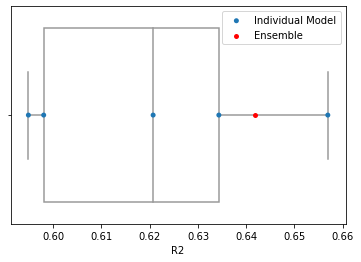

In [15]:
fig=plt.figure()
sns.boxplot(r2s,color="w")
a=sns.swarmplot(r2s,label='Individual Model')
b=sns.swarmplot([ensR2],label='Ensemble',color='red')
plt.xlabel('R2')
plt.legend()
plt.savefig('model_ensemble_testR2.png',dpi=300)

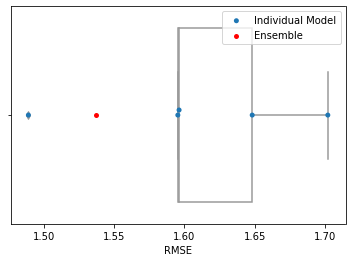

In [16]:
fig=plt.figure()
sns.boxplot(rmses,color="w")
a=sns.swarmplot(rmses,label='Individual Model')
b=sns.swarmplot([ensRMSE],label='Ensemble',color='red')
plt.xlabel('RMSE')
plt.legend()
plt.savefig('model_ensemble_testRMSE.png',dpi=300)

In [17]:
print(f'Mean R2: {np.mean(r2s)}')
print(f'Ensemble R2: {ensR2}')
print('--------------')
print(f'Mean RMSE: {np.mean(rmses)}')
print(f'Ensemble RMSE: {ensRMSE}')

Mean R2: 0.6209610254154737
Ensemble R2: 0.641898887489583
--------------
Mean RMSE: 1.6061806301197243
Ensemble RMSE: 1.5373814834708632


# Lower Model Parameter sweep

In [12]:
wdb_data=pd.read_csv('2dlparam_wandb_sweep.csv')

In [14]:
def gen_key(row):
    return re.split(r'aqsol_scaf_2d_\d_',row['Name'])[1]

In [16]:
wdb_data['Keys']=wdb_data.apply(lambda row: gen_key(row),axis=1)

In [21]:
todo=set([re.split(r'2Dlowparamsweep/aqsol_scaf_2d_\d_',x)[1] for x in glob.glob('2Dlowparamsweep/*testdic.pi')])

In [63]:
prefix='2Dlowparamsweep/aqsol_scaf_2d_'
data={}
for suffix in todo:
    key=suffix.split('_testdic.pi')[0]
    
    if len(wdb_data[wdb_data['Keys']==key]['fold'])!=3:
        continue
    #print(suffix)
    data[key]={
            'f0R2':0,
            'f0RMSE':0,
            'f1R2':0,
            'f1RMSE':0,
            'f2R2':0,
            'f2RMSE':0,
            'time':[],
            'ccvR2':0,
            'ccvRMSE':0,
            'parameters':0
        }
    
    data[key]['parameters']=wdb_data[wdb_data['Keys']==key]['Parameters'].values[0]
    
    all_preds=np.array([])
    all_golds=np.array([])
    for fold in ['0','1','2']:
        filename=prefix+fold+'_'+suffix
        fRMSE,fR2,_,_,fpred,fgold=get_test_data(filename)
        all_preds=np.append(all_preds,fpred.tolist())
        all_golds=np.append(all_golds,fgold.tolist())
        
        data[key]['f'+fold+'R2']=fR2
        data[key]['f'+fold+'RMSE']=fRMSE
        
        data[key]['time'].append(wdb_data[(wdb_data['Keys']==key) & (wdb_data['fold']==int(fold))]['Runtime'].values[0])
    
    ccvRMSE,ccvR2=get_stats(all_preds,all_golds)
    data[key]['ccvR2']=ccvR2
    data[key]['ccvRMSE']=ccvRMSE
    data[key]['time']=np.mean(data[key]['time'])

In [74]:
with open('2dlparam_sweep_analysis.csv','w') as outfile:
    outfile.write('Model,Params,Time,ccvR2,ccvRMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE\n')
    for key in data:
        p=data[key]['parameters']
        t=data[key]['time']
        cR2=data[key]['ccvR2']
        cRMSE=data[key]['ccvRMSE']
        f0r2=data[key]['f0R2']
        f0rmse=data[key]['f0RMSE']
        f1r2=data[key]['f1R2']
        f1rmse=data[key]['f1RMSE']
        f2r2=data[key]['f2R2']
        f2rmse=data[key]['f2RMSE']
        outfile.write(f'{key},{p},{t},{cR2},{cRMSE},{f0r2},{f0rmse},{f1r2},{f1rmse},{f2r2},{f2rmse}\n')

In [76]:
analysis=pd.read_csv('2dlparam_sweep_analysis.csv')

In [92]:
a=analysis.sort_values('ccvR2',ascending=False)

In [94]:
a[:5]

,Model,Params,Time,ccvR2,ccvRMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE
58,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,336385,14245.666667,0.693493,1.376512,0.763999,1.260479,0.563321,1.681636,0.705654,1.125983
26,drop0.1_ldist0.33_lattn0.5_Ndense1_heads16_dmo...,1988097,16114.000000,0.674403,1.398371,0.762446,1.213010,0.527875,1.781047,0.695637,1.105903
27,drop0.1_ldist0.0_lattn0.5_Ndense1_heads8_dmode...,336385,18326.666667,0.671782,1.453960,0.764226,1.239469,0.539156,1.856997,0.684553,1.165120
4,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,502529,16432.666667,0.662179,1.467449,0.768901,1.231114,0.464807,1.972056,0.733326,1.027569
29,drop0.1_ldist0.0_lattn0.25_Ndense1_heads8_dmod...,502529,17841.000000,0.660254,1.495245,0.764070,1.220626,0.479731,2.006211,0.716698,1.092144


# Even lower model parameter sweep

In [16]:
wdb_data=pd.read_csv('2delowparam_wandb_sweep.csv')

In [20]:
wdb_data['Name'][57]

'rose-sweep-158'

In [25]:
wdb_data['Keys']=wdb_data.apply(lambda row: gen_key(row),axis=1)

In [30]:
wdb_data=wdb_data[wdb_data['Keys']!='na']

In [32]:
todo=set([re.split(r'2Delowsweep/aqsol_scaf_2d_\d_',x)[1] for x in glob.glob('2Delowsweep/*testdic.pi')])

In [38]:
prefix='2Delowsweep/aqsol_scaf_2d_'
data={}
for suffix in todo:
    key=suffix.split('_testdic.pi')[0]
    
    if len(wdb_data[wdb_data['Keys']==key]['fold'])!=3:
        continue
    #print(suffix)
    data[key]={
            'f0R2':0,
            'f0RMSE':0,
            'f1R2':0,
            'f1RMSE':0,
            'f2R2':0,
            'f2RMSE':0,
            'time':[],
            'ccvR2':0,
            'ccvRMSE':0,
            'parameters':0
        }
    
    data[key]['parameters']=wdb_data[wdb_data['Keys']==key]['Parameters'].values[0]
    
    all_preds=np.array([])
    all_golds=np.array([])
    for fold in ['0','1','2']:
        filename=prefix+fold+'_'+suffix
        fRMSE,fR2,_,_,fpred,fgold=get_test_data(filename)
        all_preds=np.append(all_preds,fpred.tolist())
        all_golds=np.append(all_golds,fgold.tolist())
        
        data[key]['f'+fold+'R2']=fR2
        data[key]['f'+fold+'RMSE']=fRMSE
        
        data[key]['time'].append(wdb_data[(wdb_data['Keys']==key) & (wdb_data['fold']==int(fold))]['Runtime'].values[0])
    
    ccvRMSE,ccvR2=get_stats(all_preds,all_golds)
    data[key]['ccvR2']=ccvR2
    data[key]['ccvRMSE']=ccvRMSE
    data[key]['time']=np.mean(data[key]['time'])

In [41]:
with open('2delowparam_sweep_analysis.csv','w') as outfile:
    outfile.write('Model,Params,Time,ccvR2,ccvRMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE\n')
    for key in data:
        p=data[key]['parameters']
        t=data[key]['time']
        cR2=data[key]['ccvR2']
        cRMSE=data[key]['ccvRMSE']
        f0r2=data[key]['f0R2']
        f0rmse=data[key]['f0RMSE']
        f1r2=data[key]['f1R2']
        f1rmse=data[key]['f1RMSE']
        f2r2=data[key]['f2R2']
        f2rmse=data[key]['f2RMSE']
        outfile.write(f'{key},{p},{t},{cR2},{cRMSE},{f0r2},{f0rmse},{f1r2},{f1rmse},{f2r2},{f2rmse}\n')

In [47]:
analysis=pd.read_csv('2delowparam_sweep_analysis.csv')

In [48]:
a=analysis.sort_values('ccvR2',ascending=False)

In [49]:
a[:10]

,Model,Params,Time,ccvR2,ccvRMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE
12,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,22657.0,10584.333333,0.724018,1.297053,0.779879,1.186600,0.626108,1.581718,0.716287,1.066467
68,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,128385.0,15865.666667,0.717589,1.287320,0.778099,1.157686,0.594229,1.610602,0.737821,1.018571
61,drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmo...,22657.0,11340.333333,0.714495,1.326332,0.791849,1.166481,0.575278,1.657057,0.745215,1.082189
59,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,86273.0,11446.000000,0.712546,1.301905,0.788677,1.165854,0.587546,1.602126,0.710820,1.076571
37,drop0.1_ldist0.0_lattn0.5_Ndense1_heads8_dmode...,44289.0,17217.666667,0.709586,1.337051,0.785094,1.204827,0.575254,1.682398,0.737254,1.039836
43,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,33473.0,14399.000000,0.709424,1.336773,0.774115,1.171287,0.569960,1.715117,0.751812,1.023508
55,drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmo...,44289.0,17494.333333,0.708226,1.326148,0.781647,1.197882,0.569482,1.687934,0.746639,0.996091
50,drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmo...,86273.0,11495.333333,0.703142,1.332283,0.783536,1.153977,0.563747,1.665753,0.728845,1.103952
63,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,44289.0,17296.000000,0.702794,1.344910,0.781050,1.230008,0.555530,1.702693,0.748798,1.007228
31,drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmo...,170497.0,17297.000000,0.702781,1.353873,0.797551,1.119592,0.552841,1.778445,0.738229,1.040570


In [56]:
print([x for x in analysis[analysis['Params']==analysis['Params'].min()]['Model']])

['drop0.1_ldist0.33_lattn0.33_Ndense1_heads8_dmodel32_nsl4', 'drop0.1_ldist0.33_lattn0.33_Ndense1_heads16_dmodel32_nsl4', 'drop0.1_ldist0.0_lattn0.25_Ndense1_heads8_dmodel32_nsl4', 'drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmodel32_nsl4', 'drop0.1_ldist0.0_lattn0.5_Ndense1_heads8_dmodel32_nsl4', 'drop0.1_ldist0.0_lattn0.33_Ndense1_heads8_dmodel32_nsl4', 'drop0.1_ldist0.0_lattn0.25_Ndense1_heads16_dmodel32_nsl4', 'drop0.1_ldist0.33_lattn0.5_Ndense1_heads16_dmodel32_nsl4', 'drop0.1_ldist0.33_lattn0.5_Ndense1_heads8_dmodel32_nsl4', 'drop0.1_ldist0.33_lattn0.25_Ndense1_heads8_dmodel32_nsl4', 'drop0.1_ldist0.33_lattn0.25_Ndense1_heads16_dmodel32_nsl4', 'drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmodel32_nsl4']


# Even Even lower model param sweep

In [4]:
wdb_data=pd.read_csv('2dexexlow_sweep.csv')

In [5]:
wdb_data['Keys']=wdb_data.apply(lambda row: gen_key(row),axis=1)

In [6]:
wdb_data=wdb_data[wdb_data['Keys']!='na']

In [11]:
todo=set([re.split(r'2Dexexlowsweep/aqsol_scaf_2d_\d_',x)[1] for x in glob.glob('2Dexexlowsweep/*testdic.pi')])

In [12]:
len(todo)

72

In [15]:
prefix='2Dexexlowsweep/aqsol_scaf_2d_'
data={}
for suffix in todo:
    key=suffix.split('_testdic.pi')[0]
    
    if len(wdb_data[wdb_data['Keys']==key]['fold'])!=3:
        continue
    #print(suffix)
    data[key]={
            'f0R2':0,
            'f0RMSE':0,
            'f1R2':0,
            'f1RMSE':0,
            'f2R2':0,
            'f2RMSE':0,
            'time':[],
            'ccvR2':0,
            'ccvRMSE':0,
            'parameters':0
        }
    
    data[key]['parameters']=wdb_data[wdb_data['Keys']==key]['Parameters'].values[0]
    
    all_preds=np.array([])
    all_golds=np.array([])
    for fold in ['0','1','2']:
        filename=prefix+fold+'_'+suffix
        fRMSE,fR2,_,_,fpred,fgold=get_test_data(filename)
        all_preds=np.append(all_preds,fpred.tolist())
        all_golds=np.append(all_golds,fgold.tolist())
        
        data[key]['f'+fold+'R2']=fR2
        data[key]['f'+fold+'RMSE']=fRMSE
        
        data[key]['time'].append(wdb_data[(wdb_data['Keys']==key) & (wdb_data['fold']==int(fold))]['Runtime'].values[0])
    
    ccvRMSE,ccvR2=get_stats(all_preds,all_golds)
    data[key]['ccvR2']=ccvR2
    data[key]['ccvRMSE']=ccvRMSE
    data[key]['time']=np.mean(data[key]['time'])

In [16]:
with open('2dexexlow_sweep_analysis.csv','w') as outfile:
    outfile.write('Model,Params,Time,ccvR2,ccvRMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE\n')
    for key in data:
        p=data[key]['parameters']
        t=data[key]['time']
        cR2=data[key]['ccvR2']
        cRMSE=data[key]['ccvRMSE']
        f0r2=data[key]['f0R2']
        f0rmse=data[key]['f0RMSE']
        f1r2=data[key]['f1R2']
        f1rmse=data[key]['f1RMSE']
        f2r2=data[key]['f2R2']
        f2rmse=data[key]['f2RMSE']
        outfile.write(f'{key},{p},{t},{cR2},{cRMSE},{f0r2},{f0rmse},{f1r2},{f1rmse},{f2r2},{f2rmse}\n')

In [18]:
analysis=pd.read_csv('2dexexlow_sweep_analysis.csv')

In [19]:
a=analysis.sort_values('ccvR2',ascending=False)

In [20]:
a[:10]

,Model,Params,Time,ccvR2,ccvRMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE
49,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,11905.0,18062.333333,0.723395,1.271156,0.792751,1.129759,0.595477,1.605009,0.744085,0.997642
25,drop0.1_ldist0.0_lattn0.5_Ndense1_heads8_dmode...,11905.0,18005.000000,0.713022,1.349575,0.786084,1.271721,0.582039,1.680299,0.756231,1.011740
44,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,9057.0,14170.000000,0.707467,1.296556,0.789778,1.131048,0.576658,1.659772,0.748098,1.004622
10,drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmo...,11905.0,18720.333333,0.704468,1.368903,0.790735,1.233282,0.563023,1.770214,0.751802,0.983524
8,drop0.1_ldist0.33_lattn0.5_Ndense1_heads16_dmo...,11905.0,16983.666667,0.702940,1.350481,0.761715,1.299268,0.589597,1.661449,0.735758,1.011498
31,drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmo...,9057.0,15562.333333,0.698271,1.335783,0.782118,1.205876,0.559274,1.693882,0.739193,1.014792
40,drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmod...,3361.0,7043.000000,0.697291,1.404017,0.774009,1.213606,0.551453,1.817341,0.738133,1.066994
17,drop0.1_ldist0.33_lattn0.5_Ndense1_heads16_dmo...,9057.0,13973.666667,0.696191,1.345234,0.782712,1.180140,0.574781,1.726870,0.739241,1.026830
47,drop0.1_ldist0.33_lattn0.25_Ndense1_heads16_dm...,11905.0,17170.333333,0.694297,1.377975,0.777713,1.186952,0.548559,1.800086,0.749538,1.023491
9,drop0.1_ldist0.33_lattn0.5_Ndense1_heads8_dmod...,11905.0,16888.333333,0.693476,1.388323,0.779912,1.275203,0.551774,1.775512,0.752993,1.002005


In [21]:
for thing in a[:10]['Model']:
    print(thing)

drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmodel16_nsl8
drop0.1_ldist0.0_lattn0.5_Ndense1_heads8_dmodel16_nsl8
drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmodel16_nsl6
drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmodel16_nsl8
drop0.1_ldist0.33_lattn0.5_Ndense1_heads16_dmodel16_nsl8
drop0.1_ldist0.0_lattn0.33_Ndense1_heads16_dmodel16_nsl6
drop0.1_ldist0.0_lattn0.5_Ndense1_heads16_dmodel16_nsl2
drop0.1_ldist0.33_lattn0.5_Ndense1_heads16_dmodel16_nsl6
drop0.1_ldist0.33_lattn0.25_Ndense1_heads16_dmodel16_nsl8
drop0.1_ldist0.33_lattn0.5_Ndense1_heads8_dmodel16_nsl8


# Final low parameter model sweep

In [7]:
wdb_data=pd.read_csv('2dex3low_sweep.csv')
wdb_data['Keys']=wdb_data.apply(lambda row: gen_key(row),axis=1)
wdb_data=wdb_data[wdb_data['Keys']!='na']

In [9]:
todo=set([re.split(r'2Dex3sweep/aqsol_scaf_2d_\d_',x)[1] for x in glob.glob('2Dex3sweep/*testdic.pi')])

In [10]:
len(todo)

66

In [11]:
prefix='2Dex3sweep/aqsol_scaf_2d_'
data={}
for suffix in todo:
    key=suffix.split('_testdic.pi')[0]
    
    if len(wdb_data[wdb_data['Keys']==key]['fold'])!=3:
        continue
    #print(suffix)
    data[key]={
            'f0R2':0,
            'f0RMSE':0,
            'f1R2':0,
            'f1RMSE':0,
            'f2R2':0,
            'f2RMSE':0,
            'time':[],
            'ccvR2':0,
            'ccvRMSE':0,
            'parameters':0
        }
    
    data[key]['parameters']=wdb_data[wdb_data['Keys']==key]['Parameters'].values[0]
    
    all_preds=np.array([])
    all_golds=np.array([])
    for fold in ['0','1','2']:
        filename=prefix+fold+'_'+suffix
        fRMSE,fR2,_,_,fpred,fgold=get_test_data(filename)
        all_preds=np.append(all_preds,fpred.tolist())
        all_golds=np.append(all_golds,fgold.tolist())
        
        data[key]['f'+fold+'R2']=fR2
        data[key]['f'+fold+'RMSE']=fRMSE
        
        data[key]['time'].append(wdb_data[(wdb_data['Keys']==key) & (wdb_data['fold']==int(fold))]['Runtime'].values[0])
    
    ccvRMSE,ccvR2=get_stats(all_preds,all_golds)
    data[key]['ccvR2']=ccvR2
    data[key]['ccvRMSE']=ccvRMSE
    data[key]['time']=np.mean(data[key]['time'])

In [12]:
with open('2dex3_sweep_analysis.csv','w') as outfile:
    outfile.write('Model,Params,Time,ccvR2,ccvRMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE\n')
    for key in data:
        p=data[key]['parameters']
        t=data[key]['time']
        cR2=data[key]['ccvR2']
        cRMSE=data[key]['ccvRMSE']
        f0r2=data[key]['f0R2']
        f0rmse=data[key]['f0RMSE']
        f1r2=data[key]['f1R2']
        f1rmse=data[key]['f1RMSE']
        f2r2=data[key]['f2R2']
        f2rmse=data[key]['f2RMSE']
        outfile.write(f'{key},{p},{t},{cR2},{cRMSE},{f0r2},{f0rmse},{f1r2},{f1rmse},{f2r2},{f2rmse}\n')

In [22]:
analysis=pd.read_csv('2dex3_sweep_analysis.csv')
a=analysis.sort_values('ccvR2',ascending=False)

In [23]:
a[:10]

,Model,Params,Time,ccvR2,ccvRMSE,f0R2,f0RMSE,f1R2,f1RMSE,f2R2,f2RMSE
22,drop0.1_ldist0.0_lattn0.5_Ndense1_heads4_dmode...,2609,17136.333333,0.695386,1.375566,0.778829,1.169465,0.544529,1.787513,0.737456,1.055427
0,drop0.1_ldist0.33_lattn0.5_Ndense1_heads4_dmod...,2609,16856.666667,0.676959,1.453522,0.766643,1.252190,0.552231,1.918755,0.720248,1.043497
18,drop0.1_ldist0.0_lattn0.5_Ndense1_heads2_dmode...,3393,22189.666667,0.676424,1.459329,0.791408,1.172359,0.524256,1.916059,0.742369,1.159075
7,drop0.1_ldist0.0_lattn0.33_Ndense1_heads4_dmod...,2609,17123.333333,0.672935,1.435651,0.777800,1.149076,0.512800,1.950715,0.733562,1.028552
17,drop0.1_ldist0.33_lattn0.33_Ndense1_heads4_dmo...,2609,17219.333333,0.670419,1.431568,0.769298,1.181908,0.522547,1.927819,0.733309,1.017386
9,drop0.1_ldist0.33_lattn0.5_Ndense1_heads8_dmod...,1041,8931.000000,0.666708,1.419226,0.749767,1.220212,0.499738,1.883005,0.745308,1.004132
4,drop0.1_ldist0.0_lattn0.5_Ndense1_heads8_dmode...,1041,9192.333333,0.665435,1.426716,0.750808,1.212139,0.525406,1.849909,0.706163,1.102432
10,drop0.1_ldist0.0_lattn0.33_Ndense1_heads4_dmod...,3393,20903.000000,0.657387,1.493671,0.779108,1.158074,0.512972,2.054285,0.746176,1.064082
14,drop0.1_ldist0.0_lattn0.25_Ndense1_heads4_dmod...,2609,16052.000000,0.657196,1.463400,0.784402,1.134220,0.481210,2.011576,0.719868,1.045008
20,drop0.1_ldist0.0_lattn0.25_Ndense1_heads4_dmod...,3393,20344.000000,0.656057,1.507337,0.789961,1.128151,0.513999,2.072253,0.745766,1.117832
